Autoencodeur avec des chiffres mnist en entrée 

In [ ]:
import keras
from keras import layers
from keras import regularizers

# size of  encoded representations
encoding_dim = 32  

# input image
input_img = keras.Input(shape=(784,))

# encoded representation of the input

encoded = layers.Dense(128, activation='relu')(input_img)
encoded = layers.Dense(64, activation='relu')(encoded)
encoded = layers.Dense(32, activation='relu',
                       activity_regularizer=regularizers.l1(10e-5))(encoded)


# reconstruction of the input

decoded = layers.Dense(784, activation='sigmoid')(encoded)


autoencoder = keras.Model(input_img, decoded)



In [ ]:
# creater encoder model
encoder = keras.Model(input_img, encoded)


# create decoder model
encoded_input = keras.Input(shape=(encoding_dim,))
# last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))


autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

# load data from mnist database
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()


x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)


(60000, 784)
(10000, 784)


In [ ]:
# train autoencoder over 100 epochs

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))


Epoch 1/100
235/235 [==============================] - 4s 14ms/step - loss: 0.2814 - val_loss: 0.1917
Epoch 2/100
235/235 [==============================] - 3s 13ms/step - loss: 0.1706 - val_loss: 0.1548
Epoch 3/100
235/235 [==============================] - 3s 13ms/step - loss: 0.1472 - val_loss: 0.1387
Epoch 4/100
235/235 [==============================] - 3s 13ms/step - loss: 0.1359 - val_loss: 0.1307
Epoch 5/100
235/235 [==============================] - 3s 13ms/step - loss: 0.1297 - val_loss: 0.1259
Epoch 6/100
235/235 [==============================] - 3s 13ms/step - loss: 0.1248 - val_loss: 0.1215
Epoch 7/100
235/235 [==============================] - 3s 13ms/step - loss: 0.1214 - val_loss: 0.1187
Epoch 8/100
235/235 [==============================] - 3s 13ms/step - loss: 0.1188 - val_loss: 0.1163
Epoch 9/100
235/235 [==============================] - 3s 13ms/step - loss: 0.1166 - val_loss: 0.1144
Epoch 10/100
235/235 [==============================] - 3s 13ms/step - loss: 0.115

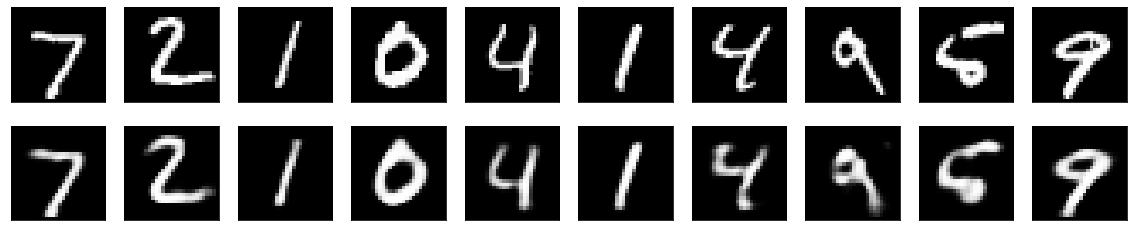

In [ ]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)


import matplotlib.pyplot as plt

n = 10  # number of digits displayed
plt.figure(figsize=(20, 4))
for i in range(n):
    #  original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    #  reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


Autoencodeur avec des couches convolutionnelles car c'est des images -> donc plus efficace

In [ ]:
import keras
from keras import layers

input_img = keras.Input(shape=(28, 28, 1))

x = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.UpSampling2D((2, 2))(x)
decoded = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')


In [ ]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))


In [ ]:
decoded_imgs = autoencoder.predict(x_test)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n + 1):
    # original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()


VAE Variational autoencoder avec toujours des digits mnist en entrée, on essaie d'en recréer en sortie de la VAE

In [ ]:
import keras
from keras import layers
from keras import regularizers
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

# encoder network, mapping inputs to the latent distribution parameters
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(28*28,))
h = layers.Dense(64, activation='relu')(inputs)
z_mean = layers.Dense(2)(h)
z_log_sigma = layers.Dense(2)(h)

# sample new similar points from the latent space 

from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], 2),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

# map sampled latent points back to reconstructed inputs

# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(2,), name='z_sampling')
x = layers.Dense(64, activation='relu')(latent_inputs)
outputs = layers.Dense(28*28, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

# cost/loss function

reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

# train VAE on MNIST digits

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))



Epoch 1/100
1875/1875 [==============================] - 10s 5ms/step - loss: 186.6680 - val_loss: 169.2125
Epoch 2/100
1875/1875 [==============================] - 9s 5ms/step - loss: 166.5129 - val_loss: 163.8123
Epoch 3/100
1875/1875 [==============================] - 9s 5ms/step - loss: 162.3188 - val_loss: 160.6712
Epoch 4/100
1875/1875 [==============================] - 8s 5ms/step - loss: 159.8197 - val_loss: 159.0890
Epoch 5/100
1875/1875 [==============================] - 9s 5ms/step - loss: 158.3132 - val_loss: 157.7733
Epoch 6/100
1875/1875 [==============================] - 9s 5ms/step - loss: 157.2630 - val_loss: 156.9004
Epoch 7/100
1875/1875 [==============================] - 9s 5ms/step - loss: 156.4094 - val_loss: 156.1604
Epoch 8/100
1875/1875 [==============================] - 9s 5ms/step - loss: 155.6492 - val_loss: 155.6607
Epoch 9/100
1875/1875 [==============================] - 9s 5ms/step - loss: 154.9583 - val_loss: 155.0646
Epoch 10/100
1875/1875 [============

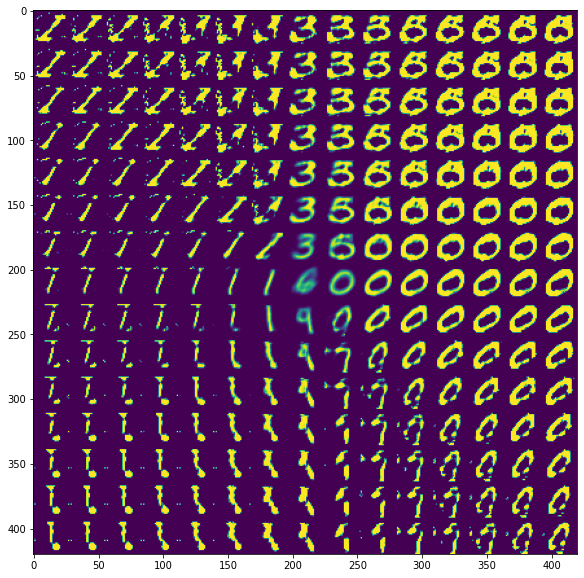

In [ ]:
n = 15  # f 15x15 digits on the figure
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)


for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()


In [ ]:
print(grid_x)
print(grid_y)

[-15.         -12.85714286 -10.71428571  -8.57142857  -6.42857143
  -4.28571429  -2.14285714   0.           2.14285714   4.28571429
   6.42857143   8.57142857  10.71428571  12.85714286  15.        ]
[-15.         -12.85714286 -10.71428571  -8.57142857  -6.42857143
  -4.28571429  -2.14285714   0.           2.14285714   4.28571429
   6.42857143   8.57142857  10.71428571  12.85714286  15.        ]
